# Assignment #3

##  Implementing the LoG scale blob detector (60 points):

Implement the Laplacian of Gaussian blob detector including scale space tracking. For this, first write a function `LoG(sigma=1,size=19)`, in which the first argument is the parameter of the Gaussian kernel and the second argument is the overall image size of the filter (here by default 19x19 pixels). The function should return a numpy array with the filter values. At each pixel (x,y), the LoG has the value of (note, that the values have to be CENTERED in the window!!):

$$\textrm{LoG}(x,y)=-\frac{1}{\pi \sigma^4}(1-\frac{x^2+y^2}{2\sigma^2})e^{-\frac{x^2+y^2}{2\sigma^2}}$$

Insert code that shows LoG filters for sigmas from 1 to 10 in steps of 1 with a size of
19 pixels.

Insert another function called `filterImg(img,fil)`, which performs a convolution of img with fil and returns the filtered image as its return value. MAKE SURE that the return image has the SAME size as the input image img!!!

Insert another function called `trackScale(img,sigmas,size,threshold)` that

```
1. Creates len(sigmas) LoG filters with the sigmas in the array for the specified size
2. Filters img with each LoG filter
3. For each pixel in the stack of filtered images, finds the maximum value and stores this in a return array called totScale
4. Plots the input picture img with overlays of the SCALED blobs that were found similar to the pictures in class on slides 79,84
```

Use the following picture (again, you may need to convert to PNG so you can read it in with matplotlib code)
 https://img1.southernliving.timeinc.net/sites/default/files/styles/4_3_horizontal_inbody_900x506/public/image/2018/07/main/the_sunflower_fields_at_neuse_river_greenway_trail.jpg?itok=ZOlvAuIg&1532035249

Insert code that uses good parameters for sigmas, size, and threshold so that you can find as many sunflower “blobs” as possible.

## Setup

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import time
import numpy as np # this is the only math-ish library,

import urllib
from PIL import Image
from tqdm.notebook import tqdm

%matplotlib inline

In [2]:
def rgb2gray(rgb):
    
    r, g, b = rgb[:,:,0], rgb[:,:,1], rgb[:,:,2]
    gray = 0.2989 * r + 0.5870 * g + 0.1140 * b
    
    return gray

In [3]:
sigmas = np.linspace(1,10,10)
size = 19

## Load image

In [4]:
prof = 'https://img1.southernliving.timeinc.net/sites/default/files/styles/4_3_horizontal_inbody_900x506/public/image/2018/07/main/the_sunflower_fields_at_neuse_river_greenway_trail.jpg?itok=ZOlvAuIg&1532035249'
urllib.request.urlretrieve(prof,'sunflow.jpg')

jpg='sunflow'
img = Image.open(jpg+'.jpg')
img.save(jpg+".png",'png')

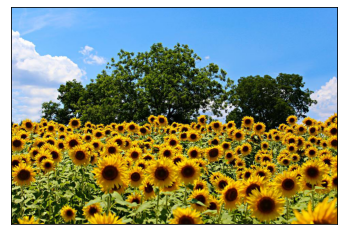

In [5]:
img = plt.imread('sunflow.png')
mrimg = rgb2gray(img)
plt.imshow(img)
plt.xticks([])
plt.yticks([])
plt.show()

## Laplacian of Gaussian blob detector

In [6]:
def LoG(sigma=1, size=19):
    """
    Laplacian of Gaussian filter
    
    Arguments
    ---------
    - sigma    : sigma (default : 1)
    - size     : filter size (default : 19)
    
    Return
    ------
    - filter   : LoG filter
    
    """
    fil = np.zeros((2*size+1, 2*size+1))
    for i in range(-size, size+1):
        for j in range(-size, size+1):
            # Normalized LoG filter
            tmp = (i*i+j*j)/(2*sigma*sigma)
            fil[i+size,j+size]=-1/(np.pi*np.power(sigma,4))*(1-tmp)*np.exp(-tmp)*(sigma**2)
    
    return fil

We have added normalization.

$$\textrm{LoG}_{\textrm{normalized}}(x,y)=\sigma^2\cdot\textrm{LoG}(x,y)=\frac{1}{\pi\sigma^2}\begin{pmatrix}\frac{x^2+y^2}{2\sigma^2}-1\end{pmatrix}e^{-\frac{x^2+y^2}{2\sigma^2}}$$

(https://math.stackexchange.com/questions/486303/normalized-laplacian-of-gaussian)

In [7]:
def filterImg(img, fil):
    """
    Convolution with weights filter
    
    Arguments
    ---------
    - img      : image
    - weights  : filter weights
    
    Return
    ------
    - filtered : filtered image
    
    """
    weights = fil.astype(float)
    filtered = np.zeros_like(img)
    
    width = int((weights.shape[1]-1)/2)
    height = int((weights.shape[0]-1)/2)
    
    for i in range(height,img.shape[1]-height):
        for j in range(width,img.shape[0]-width):
            filtered[j,i]=np.sum(weights*img[j-width:j+width+1,i-height:i+height+1])
    
    return filtered

In [8]:
def trackScale(img,sigmas,size,threshold):
    """
    Convolution with weights filter
    
    Arguments
    ---------
    - img       : image
    - sigmas    : LoG's sigmas
    - size      : LoG filter size
    - threshold : blob detection's threshold
    
    Return
    ------
    - totScale    : maximum value array
    
    """
    # stack of filtered images
    log_images = []
    for i,sigma in enumerate(sigmas):
        log_images.append(filterImg(mrimg,LoG(sigma,size)))
    log_images = np.array([i for i in log_images])
    
    # blob detection
    totScale = np.zeros(img.shape)
    blobs = []
    (h,w) = img.shape
    for i in range(1,h):
        for j in range(1,w):
            space = log_images[:,i-1:i+2,j-1:j+2]
            result = np.amax(space)
            totScale[i,j] = result
            if result >= threshold: #threshold
                z,x,y = np.unravel_index(space.argmax(),space.shape)
                blobs.append((i+x-1,j+y-1,(z+1)))
    blobs = list(set(blobs))
    print('num of blob : {}'.format(len(blobs)))
    
    # plotting
    fig, ax = plt.subplots()
    nh,nw = mrimg.shape
    ax.imshow(mrimg, cmap='gray')
    for i, blob in enumerate(tqdm(blobs)):
        y,x,r = blob
        c = plt.Circle((x, y), r, color='red', linewidth=1.5, fill=False)
        ax.add_artist(c)
    ax.plot()  
    plt.show()
    
    return totScale

## LoG Filters

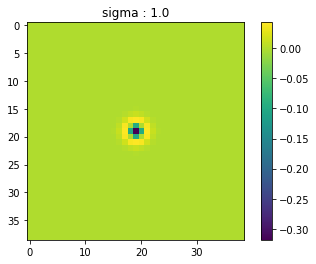

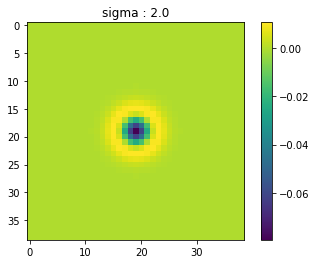

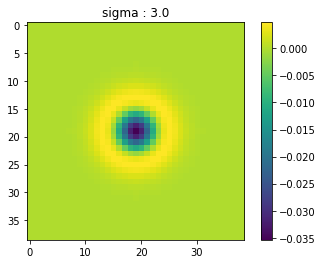

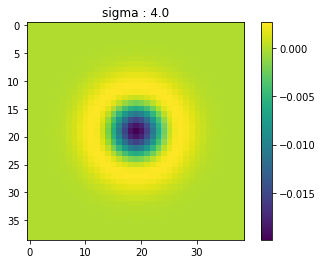

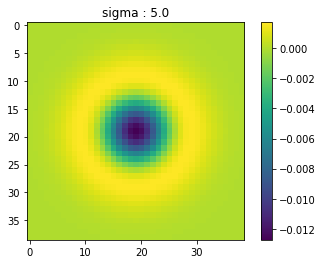

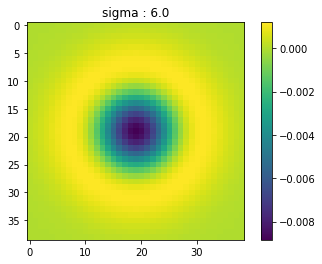

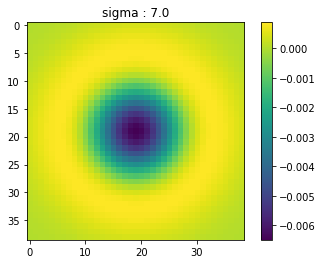

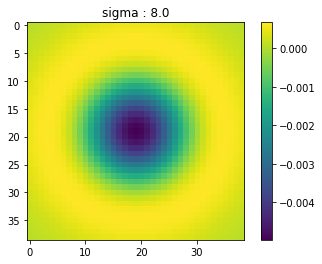

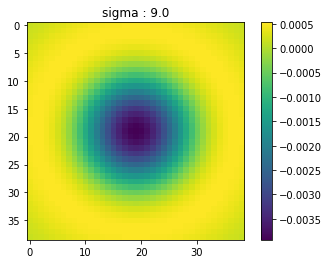

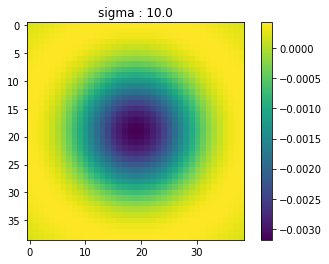

In [9]:
fil = []

for i,sigma in enumerate(sigmas):
    fil.append(LoG(sigma,size))
    plt.figure()
    plt.title('sigma : {}'.format(sigma))
    plt.imshow(fil[i])
    plt.colorbar()

## LoG Filter Convolution of image

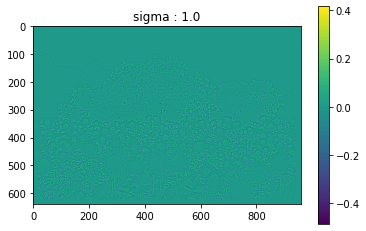

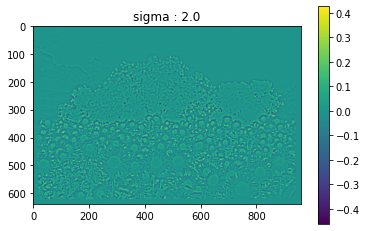

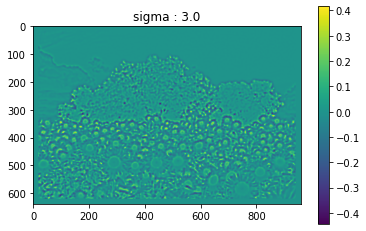

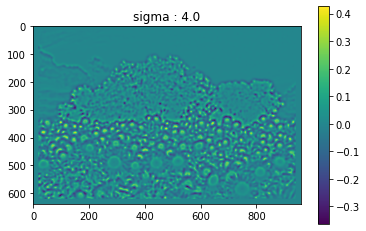

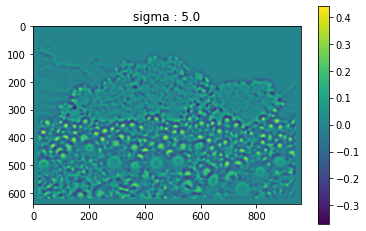

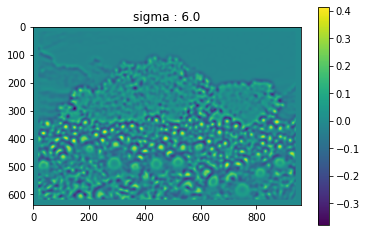

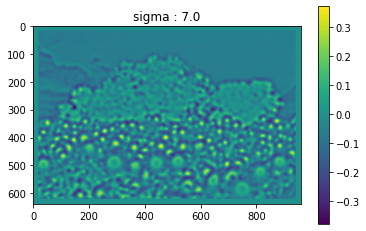

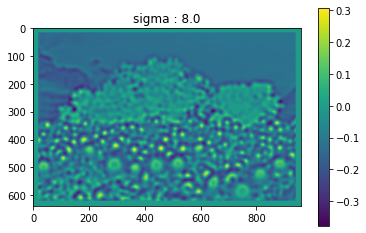

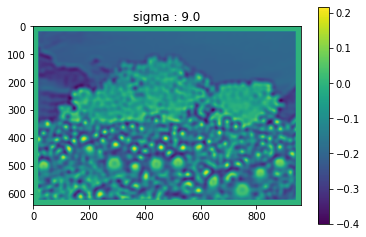

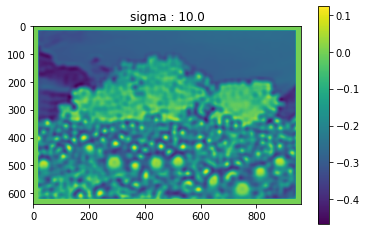

In [10]:
log_images = []

for i,sigma in enumerate(sigmas):
    log_images.append(filterImg(mrimg,LoG(sigma,size)))
    plt.figure()
    plt.title('sigma : {}'.format(sigma))
    plt.imshow(log_images[i])
    plt.colorbar()

## Result

num of blob : 3545


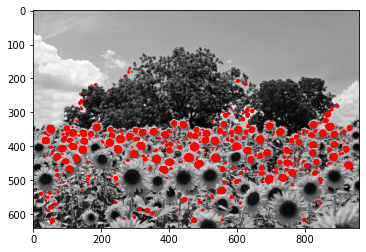

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [11]:
totScale = trackScale(mrimg,sigmas,19,0.3)
print(totScale)

## Insert code that uses good parameters for sigmas, size, and threshold so that you can find as many sunflower “blobs” as possible.

As a result of searching, the ideal sigma value is 1.6, the scale multiplier is cube root(2), and the size is sigma*6.

Additionally, the number of filters has been increased to 15.


(http://www.cs.umd.edu/~djacobs/CMSC426/Blob.pdf)

So we have newly defined the function `trackScale2(img,sigma,numFil,k,threshold)`.

In [20]:
sigma = 1.6
numFil = 15
k = np.sqrt(np.sqrt(2))
threshold = [0.2, 0.3, 0.4]

In [21]:
def trackScale2(img,sigma,numFil,k,threshold):
    """
    Convolution with weights filter
    
    Arguments
    ---------
    - img       : image
    - sigma     : LoG's sigmas
    - numFil    : Num of LoG filter
    - k         : scale multiplier
    - threshold : blob detection's threshold
    
    Return
    ------
    - totScale    : maximum value array
    
    """
    # stack of filtered images
    log_images = []
    sigmas = sigma*np.power(k,range(numFil))
    for i,sigma in enumerate(sigmas):
        size = int(np.ceil(sigma*6))
        log_images.append(filterImg(mrimg,LoG(sigma,size)))
    log_images = np.array([i for i in log_images])
    
    # blob detection
    totScale = np.zeros(img.shape)
    blobs = []
    (h,w) = img.shape
    for i in range(1,h):
        for j in range(1,w):
            space = log_images[:,i-1:i+2,j-1:j+2]
            result = np.amax(space)
            totScale[i,j] = result
            if result >= threshold: #threshold
                z,x,y = np.unravel_index(space.argmax(),space.shape)
                blobs.append((i+x-1,j+y-1,(z+1)))
    blobs = list(set(blobs))
    print('num of blob : {}'.format(len(blobs)))
    
    # plotting
    fig, ax = plt.subplots()
    nh,nw = mrimg.shape
    ax.imshow(mrimg, cmap='gray')
    for i, blob in enumerate(tqdm(blobs)):
        y,x,r = blob
        c = plt.Circle((x, y), r, color='red', linewidth=1.5, fill=False)
        ax.add_artist(c)
    ax.plot()  
    plt.show()
    
    return totScale

threshold: 0.2
num of blob : 29852


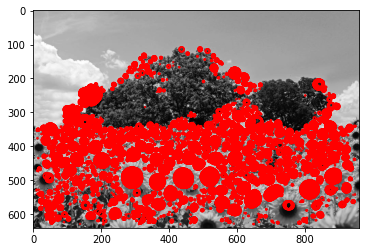

--------------------------------------------------------
threshold: 0.3
num of blob : 5812


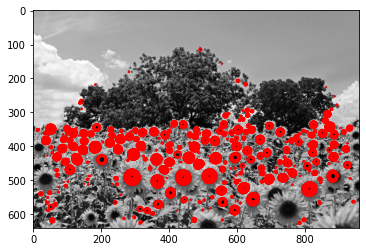

--------------------------------------------------------
threshold: 0.4
num of blob : 124


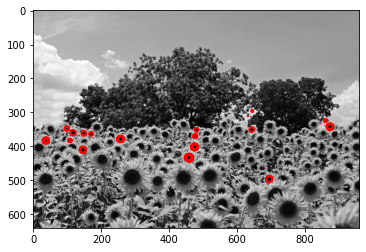

--------------------------------------------------------


In [22]:
for t in threshold:
    print('threshold: {}'.format(t))
    totScale = trackScale2(mrimg,sigma,numFil,k,t)
    print('--------------------------------------------------------')

We think that when the threshold is 0.4, there are many blobs, but useless blobs seem to be found, and when the threshold is 0.3, it seems appropriate.

---